In [1]:
# Run if on Google Colab
# !git clone https://github.com/wglao/dsml_final_project.git
# import sys
# sys.path.append('/content/dsml_final_project')

In [10]:
# imports
import os
import torch
from torch.utils.data import DataLoader
import numpy as np
from torch.optim import Adam
from models.models import NaiveMLP
from utils.data import PatientDataset
from utils.train import naive_train, noisy_train, timeseries_MSE_loss, timeseries_L2_loss, timeseries_H1_loss

ImportError: cannot import name 'naive_train' from 'utils.train' (/Users/wlao/Documents/Homework/dsml_final_project/utils/train.py)

In [3]:
HIDDEN_LAYERS = 1
NUM_EPOCHS = 1000
PRINT_EVERY = 1
LEARNING_RATE = 1e-3
BATCH_SIZE = 10
WANDB = False
NET_NAME = "naive_mlp_test"
DT = 1.
NOISE_VAR = 0.01


In [4]:
# data
health_data_file = "/Users/wlao/Documents/Homework/dsml_final_project/data/heart_failure_clinical_records_dataset.csv"
survival_file = "/Users/wlao/Documents/Homework/dsml_final_project/data/survival_function_data.csv"

train_split = 90
num_patients = 299
ids = np.random.permutation(num_patients)
split_id = int((num_patients*train_split)//100)
train_ids = ids[:split_id]
test_ids = ids[split_id:]

train_dataset = PatientDataset(health_data_file, survival_file, train_ids)
test_dataset = PatientDataset(health_data_file, survival_file, test_ids)

train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, BATCH_SIZE)

sample = next(iter(train_loader))
print(len(sample))
xs, ys = sample
print([x.shape for x in xs])
print([y.shape for y in ys])

2
[torch.Size([13]), torch.Size([13]), torch.Size([13]), torch.Size([13]), torch.Size([13]), torch.Size([13]), torch.Size([13]), torch.Size([13]), torch.Size([13]), torch.Size([13])]
[torch.Size([285]), torch.Size([285]), torch.Size([285]), torch.Size([285]), torch.Size([285]), torch.Size([285]), torch.Size([285]), torch.Size([285]), torch.Size([285]), torch.Size([285])]


/Users/wlao/Documents/Homework/dsml_final_project/utils/data.py:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  true_interp = torch.tensor([np.interp(interp_days, true_days, fn) for fn in true_data])


In [5]:
# model and optimizer
model = NaiveMLP(13,285,285,HIDDEN_LAYERS)
optimizer = Adam(model.parameters(), LEARNING_RATE)


In [6]:
loss_fn = timeseries_H1_loss
noisy_train(model, optimizer, train_loader, test_loader, NUM_EPOCHS, loss_fn, WANDB, NET_NAME, PRINT_EVERY, DT, NOISE_VAR)

Epoch: 0   Train: 8.461236079533895 (3.332606792449951)    Test: 34.87494639555613
Epoch: 1   Train: 2.4074152045779758 (2.1369757652282715)    Test: 25.636602878570557
Epoch: 2   Train: 2.4328649838765464 (2.2621679306030273)    Test: 21.226840416590374
Epoch: 3   Train: 1.667428762824447 (0.8803831934928894)    Test: 17.352905412515003
Epoch: 4   Train: 1.2574318713612027 (1.2921874523162842)    Test: 14.947378734747568
Epoch: 5   Train: 1.4460379238481875 (0.7197426557540894)    Test: 13.489784359931946
Epoch: 6   Train: 1.0263023133631106 (1.4077439308166504)    Test: 11.793048739433289
Epoch: 7   Train: 1.0394330885675218 (0.5057744979858398)    Test: 11.961814085642496
Epoch: 8   Train: 0.9071019291877747 (0.8015307784080505)    Test: 10.841219703356424
Epoch: 9   Train: 0.76341504962356 (1.1706119775772095)    Test: 12.245018849770227
Epoch: 10   Train: 0.7944730409869442 (0.8995667695999146)    Test: 11.370236823956171
Epoch: 11   Train: 0.7550541946181545 (0.9832916259765625) 

KeyboardInterrupt: 

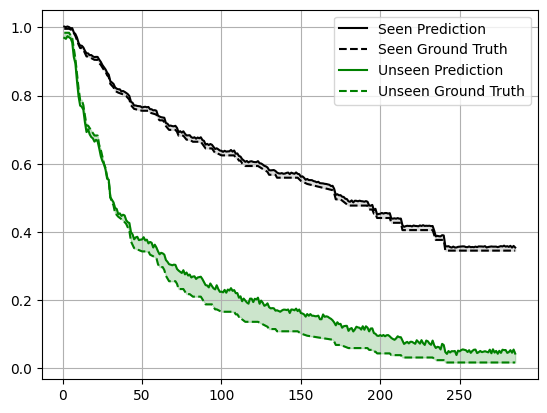

In [9]:
# inference
seen_patient, seen_truth = train_dataset[10]
unseen_patient, unseen_truth = test_dataset[0]

seen_pred = model(seen_patient)
unseen_pred = model(unseen_patient)

seen_truth = seen_truth.detach().numpy()
unseen_truth = unseen_truth.detach().numpy()
seen_pred = seen_pred.detach().numpy()
unseen_pred = unseen_pred.detach().numpy()

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1)
days = np.arange(1,286)
ax.plot(days, seen_pred, "-k", label="Seen Prediction")
ax.plot(days, seen_truth, "--k", label="Seen Ground Truth")
ax.plot(days, unseen_pred, "-g", label="Unseen Prediction")
ax.plot(days, unseen_truth, "--g", label="Unseen Ground Truth")
ax.fill_between(days, np.min(np.asarray([seen_pred, seen_truth]), axis=0), np.max(np.asarray([seen_pred, seen_truth]), axis=0), color="silver", alpha=0.5)
ax.fill_between(days, np.min(np.asarray([unseen_pred, unseen_truth]), axis=0), np.max(np.asarray([unseen_pred, unseen_truth]), axis=0), color="green", alpha=0.2)
plt.grid(True)
plt.legend(loc='best')